# Intro

The main goal of the script is to measure the quality of the state embeddings.

States encode the following set of information:

- emission distribution (in particular the mean value of the gaussian)
- co-occurence probabilities (based on the transition matrix)

Thus we can look on the state IDs in two ways:

- states simplify the emission values (the state encodes values of a continuous distribution)
- state extend the information given by emissions by the relationship between each set of values (transition probabilities)

What we expect to infer from state embeddings and daily state series:

- day / night schedule
- workday/weekend (or holiday)


## Evaluation proposed

1. Cluster state embeddings (2 clusters, expectation: day / night)
2. Cluster workday/weekend basing on emission/state ID/embeddings daily sequences (we expect that embeddings will provide more relevant information)
3. Classify weekdays and holidays



In [1]:
# !pip install sklearn

In [2]:
# !pip install holidays

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import json
import holidays  # TODO: save data, comment out
from IPython.display import display, Markdown, Latex, HTML
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from models_gaussian_2d import *  # TODO: save data, comment out
from eval_utils import *   # TODO: provide functions, comment out

2022-09-26 09:49:39.919755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-26 09:49:39.919822: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Setup
plt.rcParams.update({'figure.figsize': (20, 8)})
interval = 24 * 7 * 6

n = [4, 6, 10]
l = [2, 3, 4]
# lr = [0.05, 0.10]
lr = [0.01, 0.20]
ITER = 100000
TOLERANCE = 1e-4

# Prepare data

We will work on data in the maximal resolution (10 min intervals). The data is 2-dimensional: observed water demand and some derivative estimation.

TODO: describe how to provide data

In [5]:
# # Data
# df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
# df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
# df_main = df_main.ffill()
# df_main["V_delta"] = (np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist()))
# df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0
# df_main["V_delta"] = df_main["V_delta"].rolling(6, center=True, min_periods=2).mean()
#
# time_range = pd.DataFrame({"mtime":pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.min(), df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.max(), 24*6*(365+91))})
# df_main = pd.merge(time_range, df_main, on="mtime", how="left")
# df_main["V_delta"] = (df_main["V_delta"].bfill().ffill() + df_main["V_delta"].ffill().bfill()) / 2
#
# # Hourly aggregation
# # df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()
#
#
# # # Different derivative types
#
# # # (delata1 + delta2/2) / 2
# # df_main["V_delta_der"] = np.concatenate([np.array([0]), np.array([df_main["V_delta"].values[1] - df_main["V_delta"].values[0]]),
# #                                          df_main["V_delta"].values[2:] * 1.5 - df_main["V_delta"].values[:-2] / 2 - df_main["V_delta"].values[1:-1]])
#
# # delata1
# # df_main["V_delta_der"] = np.concatenate([np.array([0]), df_main["V_delta"].values[1:] - df_main["V_delta"].values[:-1]])
#
# # (delata1 + delta2) / 2
# df_main["V_delta_der"] = np.concatenate([np.array([0]), np.array([df_main["V_delta"].values[1] - df_main["V_delta"].values[0]]),
#                                          df_main["V_delta"].values[2:] - df_main["V_delta"].values[:-2] / 2 - df_main["V_delta"].values[1:-1] / 2])
#
#
# seasonal_changes = df_main.V_delta.rolling(interval * 6, center=True, min_periods=2).mean() \
#     .rolling(interval, center=True, min_periods=2).mean()
#
# data = df_main.loc[:, ['V_delta', 'V_delta_der']]
# data.V_delta = data.V_delta - seasonal_changes
#
# data_train = data[(df_main.mtime.dt.year == 2019)]
# data_test  = data[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1)]
#
# lengths = np.array([interval for _ in range(data_train.shape[0] // (interval))] + [
#     data_train.shape[0] - (data_train.shape[0] // (interval)) * interval])
# Y_true = data_train.values.reshape(-1, 2)
#
# with open("wodociagi/data_Piotr/data_train.pkl", "wb") as f:
#     pickle.dump((Y_true, lengths), f)

with open("wodociagi/data_Piotr/data_train.pkl", "rb") as f:
    Y_true, lengths = pickle.load(f)

Y_true

array([[-6.06411385,  0.        ],
       [-5.89740835,  0.16666667],
       [-5.89737085,  0.08333333],
       ...,
       [-5.60097926, -0.08333333],
       [-5.6009482 ,  0.        ],
       [-6.10091693, -0.5       ]])

In [6]:
# lengths_test = np.array([interval for _ in range(data_test.shape[0] // (interval))] + [
#     data_test.shape[0] - (data_test.shape[0] // (interval)) * interval])
# Y_test = data_test.values.reshape(-1, 2)
#
# with open("wodociagi/data_Piotr/data_test.pkl", "wb") as f:
#     pickle.dump((Y_test, lengths_test), f)

with open("wodociagi/data_Piotr/data_test.pkl", "rb") as f:
    Y_test, lengths_test = pickle.load(f)

Y_test

array([[-6.43421887, -0.58333333],
       [-6.43418744, -0.16666667],
       [-6.10082274,  0.33333333],
       ...,
       [-2.1562973 , -1.83333333],
       [-3.15609285, -1.66666667],
       [-4.65589418, -2.        ]])

# Build/read models

Model building section is disabled. Code for building models is archived and model reading code is provided for running.

In [7]:
def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",  # cirglaboratory
        "save_code": True,
        "group": f"models-eval",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": 0,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": 0,
        "lr": 0,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": 0, "cooc_epochs": ITER, "l_uz": 0,
               'loss_type': 'square', "scheduler": em_scheduler}

In [8]:
# # Model building
# for eta in lr:
#     for n_, l_ in zip(n, l):
#         # update configs
#         wandb_params['config'].update({"lr": eta, "l": l_, "n": n_})
#         mstep_cofig.update({"cooc_lr": eta, "l_uz": l_})
#         # train
#         hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
#                                         wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
#                                         log_config={'metrics_after_convergence': True})
#         densehmm = GaussianDenseHMM(n_, mstep_config=mstep_cofig,
#                                     covariance_type='diag', opt_schemes={"cooc"},
#                                     logging_monitor=hmm_monitor,
#                                     init_params="stmc", params="stmc", early_stopping=True)
#
#         start = time.perf_counter()
#         densehmm.fit_coocs(Y_true,lengths)
#         print(f"DONE in: {time.perf_counter() - start}")
#
#         # save model
#         u, z, z0 = densehmm.get_representations()
#
#         z_init = np.transpose(hmm_monitor.z[-1])
#         pca_z = PCA(n_components=2).fit(z_init)
#         z_traj = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]
#
#         z0_traj = list(hmm_monitor.z0)
#
#         u_init = hmm_monitor.u[-1]
#         pca_u = PCA(n_components=2).fit(u_init)
#         u_traj = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]
#
#         with open(f"wodociagi/data_Piotr/model_n{n_}_l{l_}_lr{eta}.pkl", "wb") as f:
#             pickle.dump({
#                 'means': densehmm.means_,
#                 'covars': densehmm.covars_,
#                 'transmat': densehmm.transmat_,
#                 'startprob': densehmm.startprob_,
#                 'u': u,
#                 'z': z,
#                 'z0': z0,
#                 'z0_trajectory': z0_traj,
#                 'z_trajectory': z_traj,
#                 'u_trajectory': u_traj,
#                 'omega_dtv': hmm_monitor.omega_dtv[-1],
#                 'log-lik': densehmm.score(Y_true, lengths)
#             }, f)
#
#         # provide predictions
#         states = densehmm.predict(Y_true).reshape(1, -1)
#         with open(f"wodociagi/data_Piotr/states_n{n_}_l{l_}_lr{eta}.pkl", "wb") as f:
#             pickle.dump(states, f)
#
#         # provide predictions
#         states_test = densehmm.predict(Y_test).reshape(1, -1)
#         with open(f"wodociagi/data_Piotr/states_test_n{n_}_l{l_}_lr{eta}.pkl", "wb") as f:
#             pickle.dump(states_test, f)


**Note:** you can select the model for evaluation by specifying the variables in the cell below.

In [9]:
n_ = 4
l_ = 2
eta = 0.05

# Load the model
with open(f"wodociagi/data_Piotr/model_n{n_}_l{l_}_lr{eta}.pkl", "rb") as f:
    densehmm = pickle.load(f)

with open(f"wodociagi/data_Piotr/states_n{n_}_l{l_}_lr{eta}.pkl", "rb") as f:
    states = pickle.load(f)

with open(f"wodociagi/data_Piotr/states_test_n{n_}_l{l_}_lr{eta}.pkl", "rb") as f:
    states_test = pickle.load(f)

### Train set (2019):

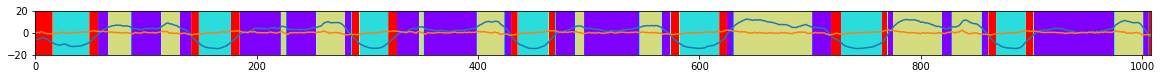

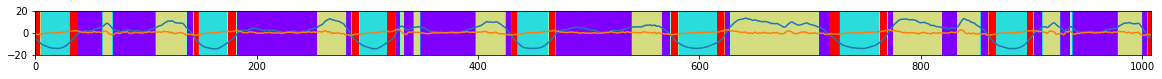

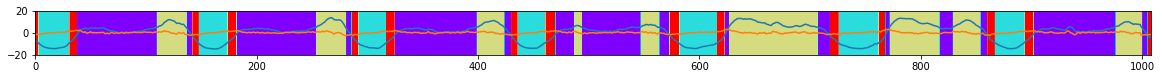

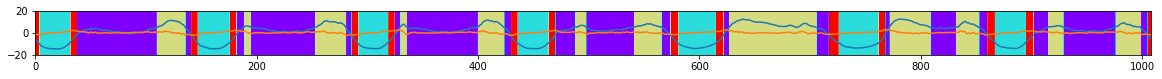

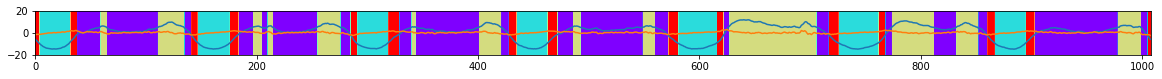

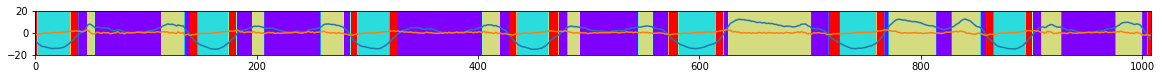

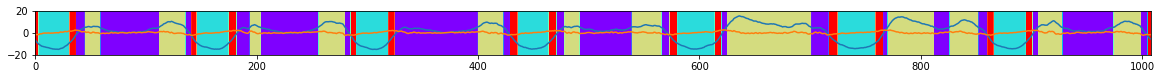

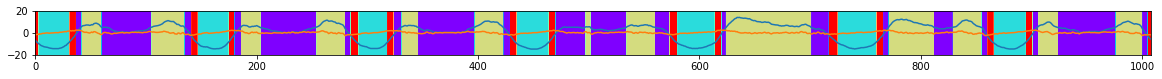

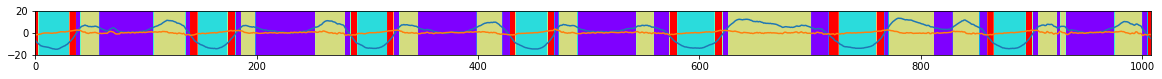

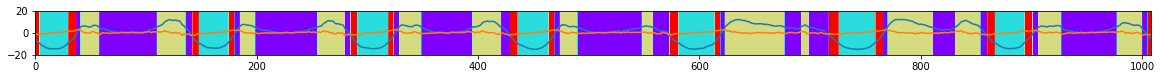

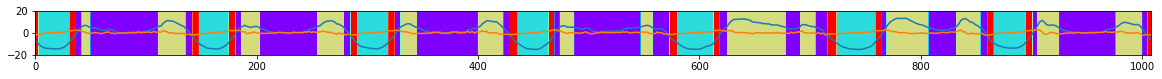

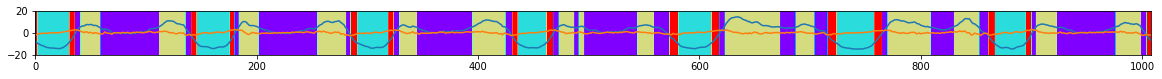

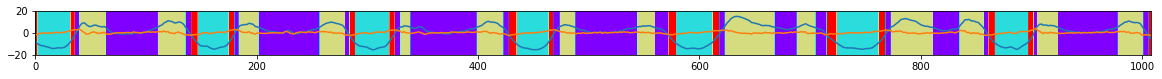

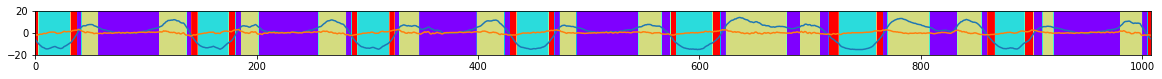

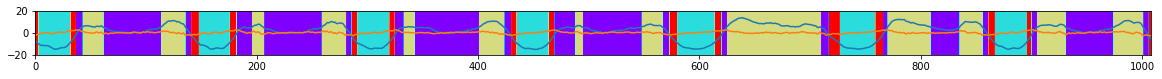

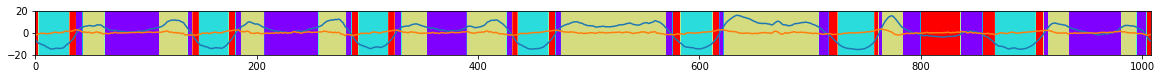

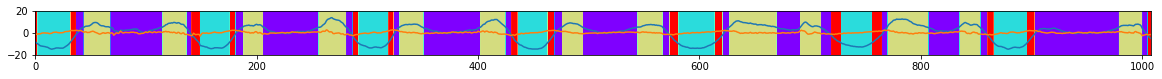

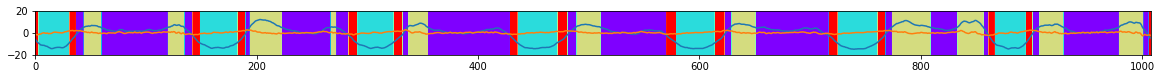

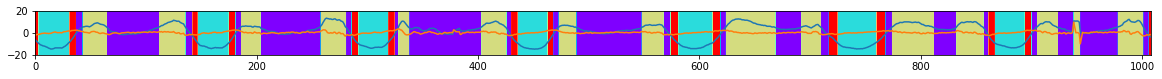

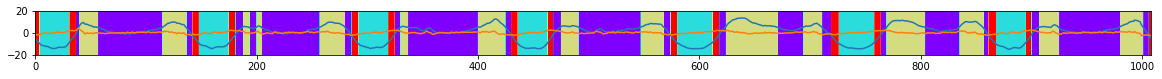

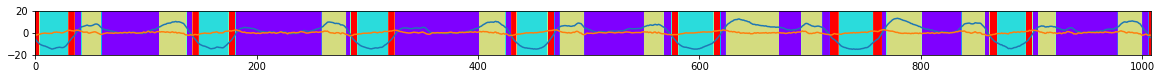

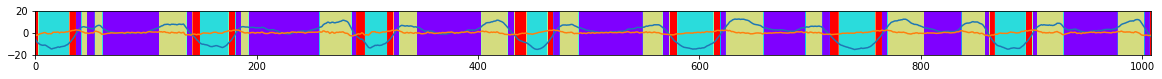

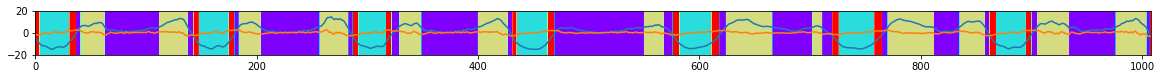

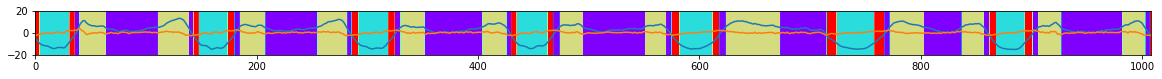

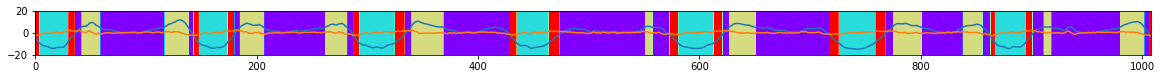

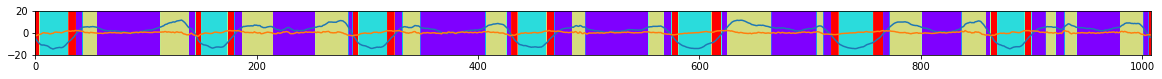

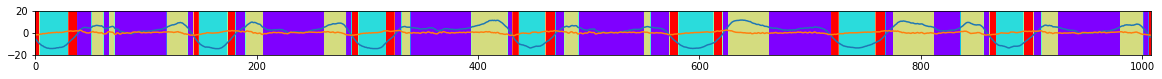

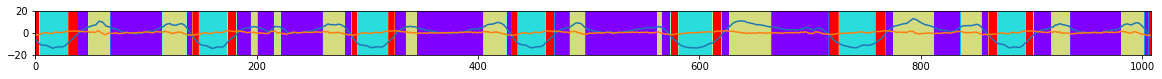

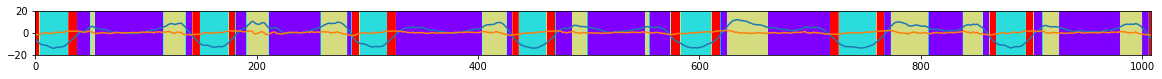

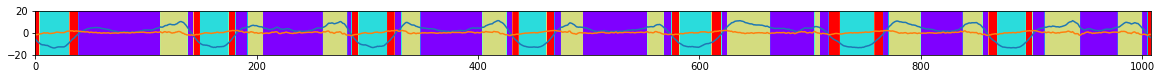

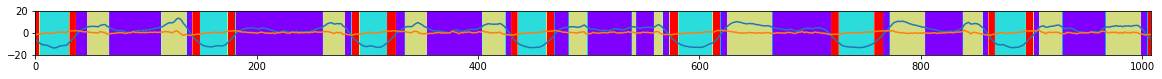

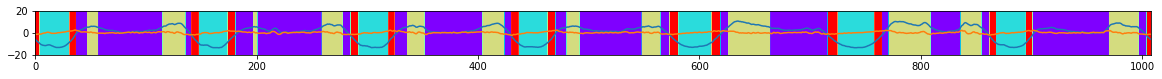

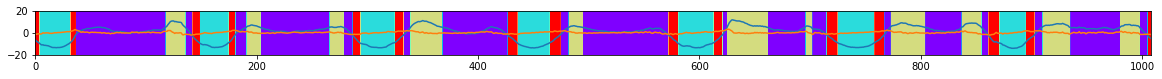

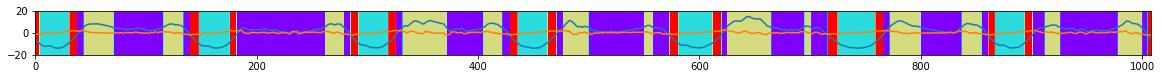

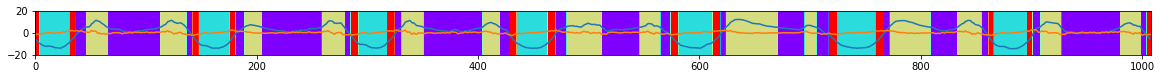

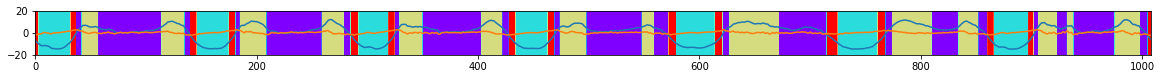

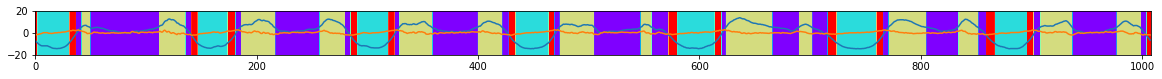

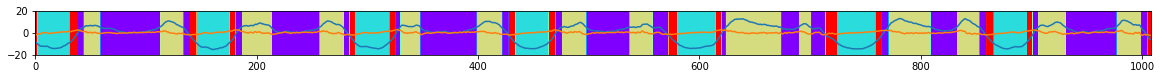

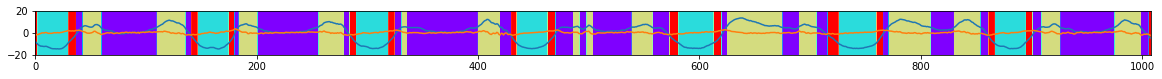

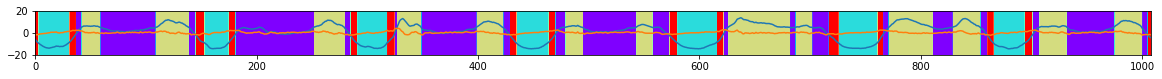

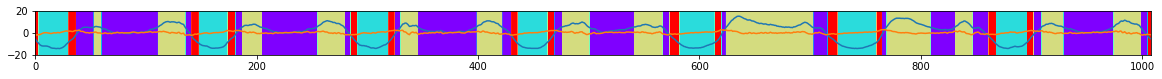

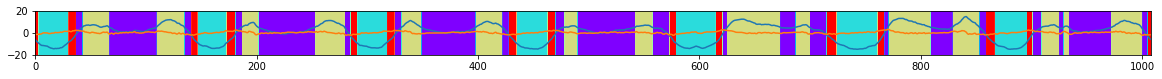

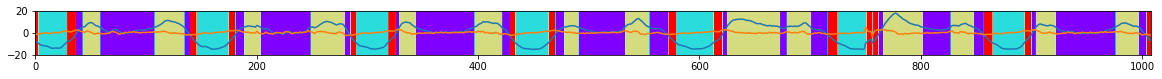

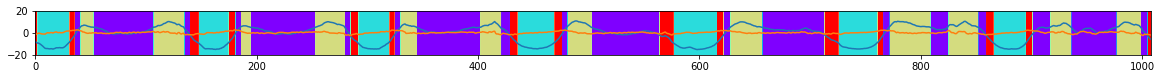

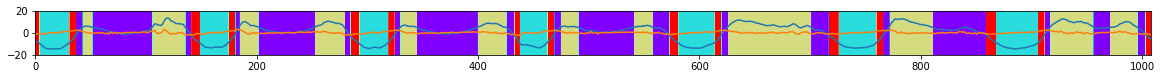

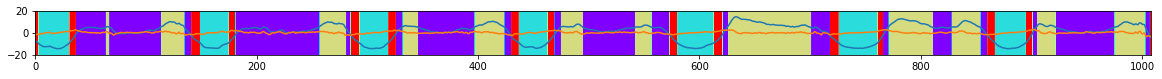

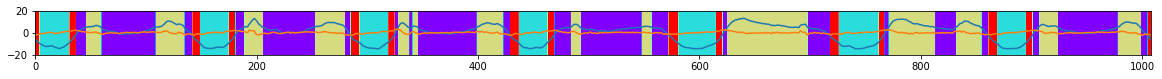

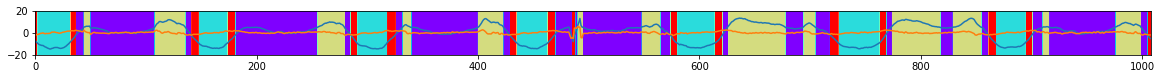

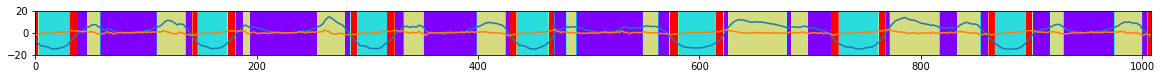

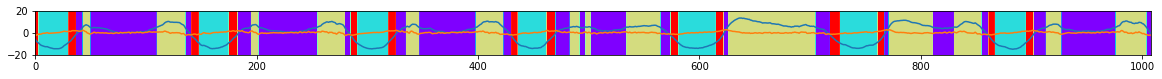

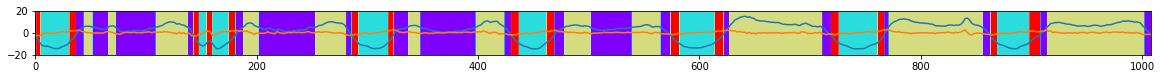

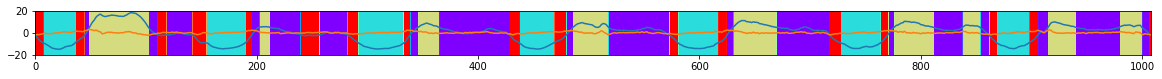

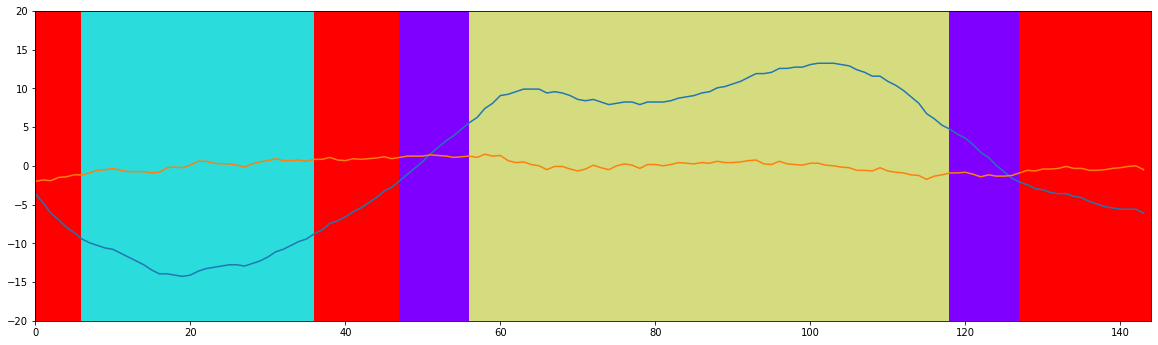

In [10]:
# Predict states
# states = densehmm.predict(Y_true).reshape(1, -1)
interval = 7 * 24 * 6

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 20))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.rainbow)
    plt.show()

### Test set (Q12020):

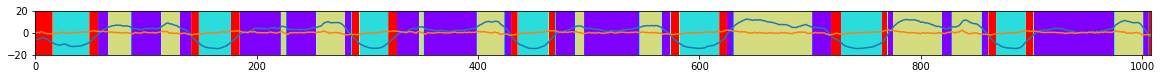

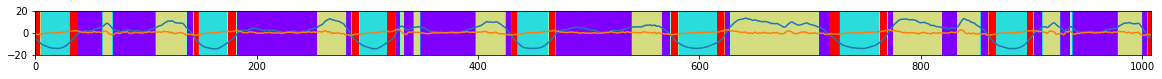

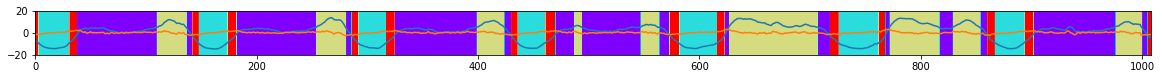

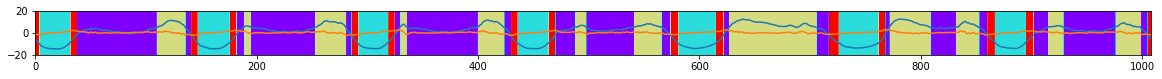

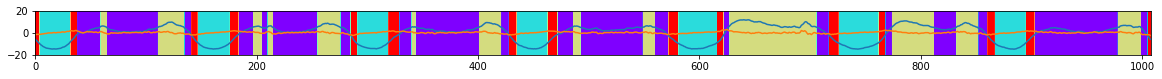

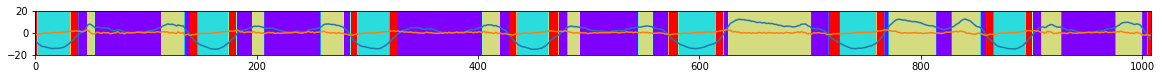

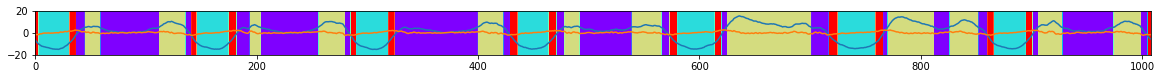

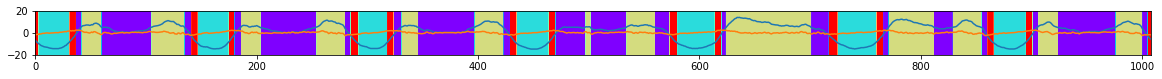

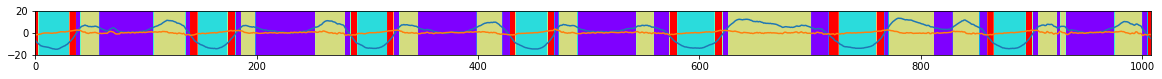

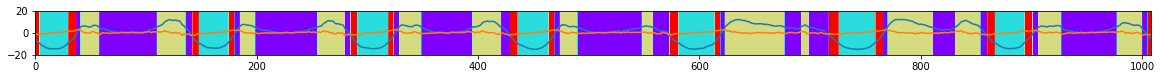

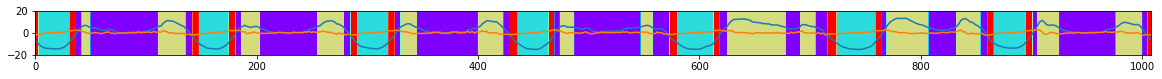

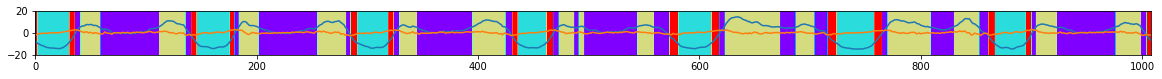

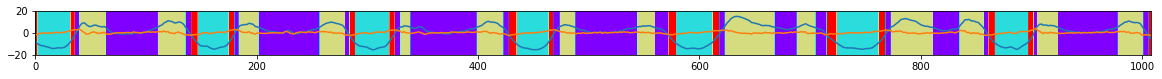

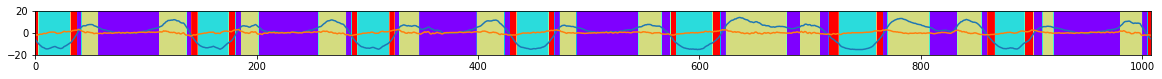

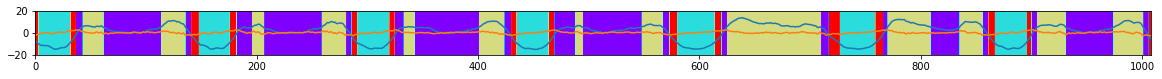

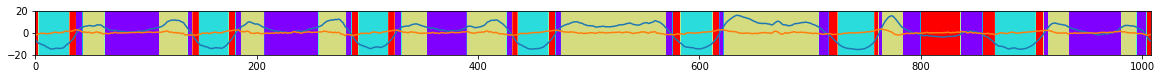

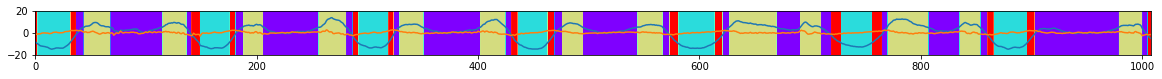

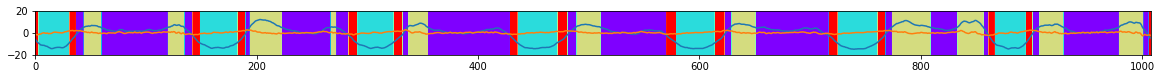

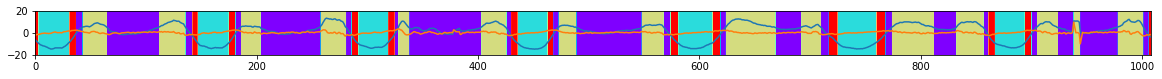

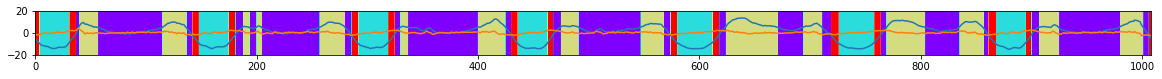

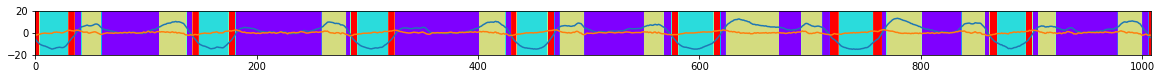

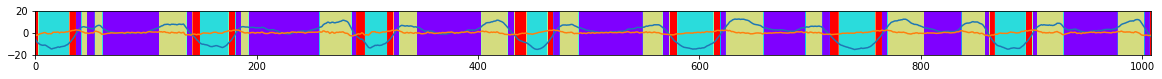

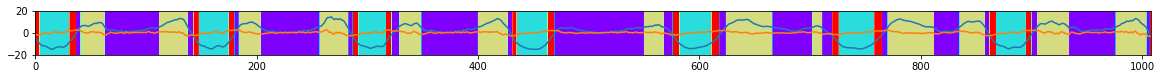

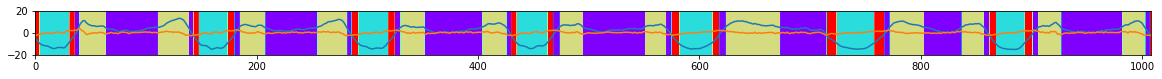

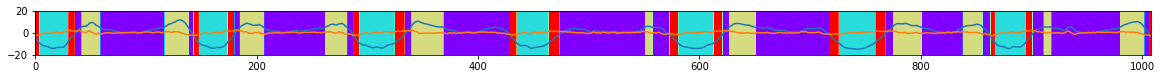

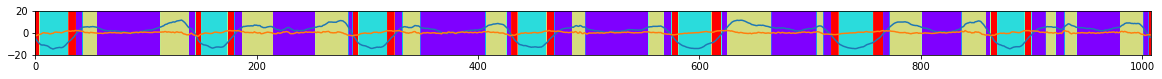

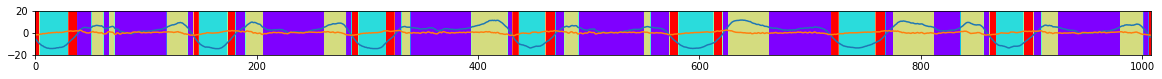

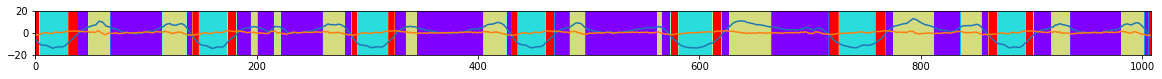

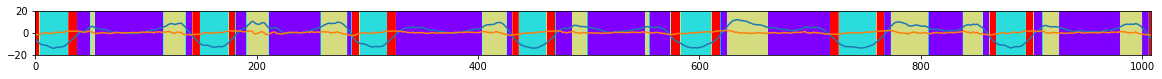

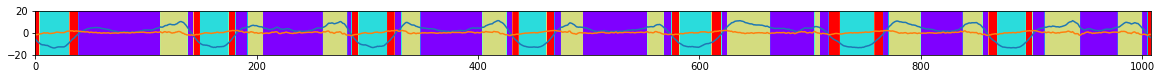

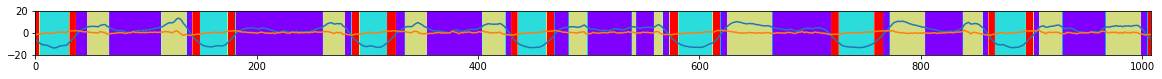

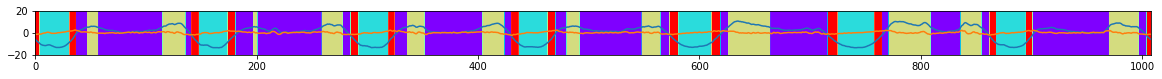

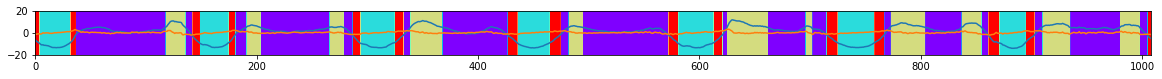

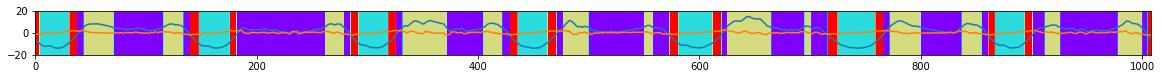

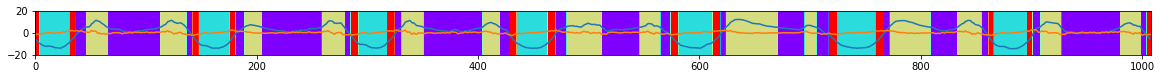

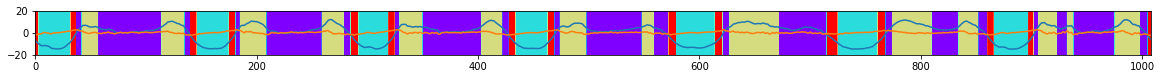

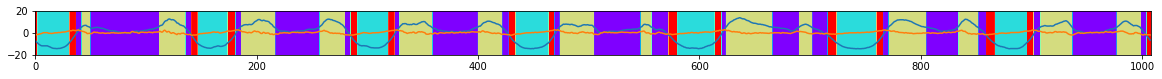

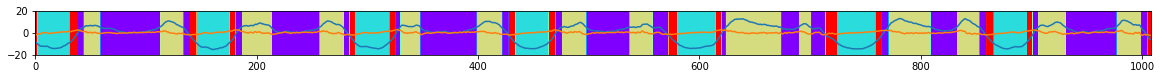

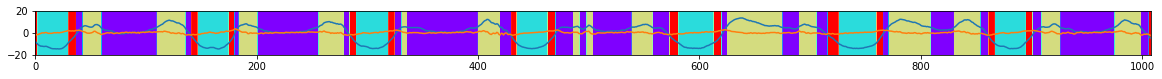

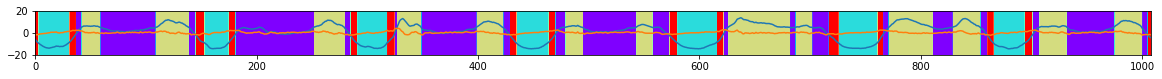

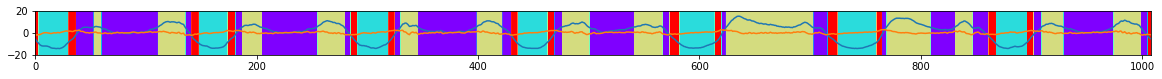

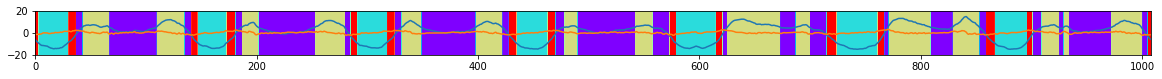

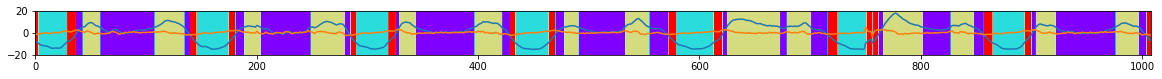

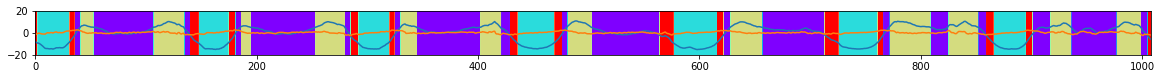

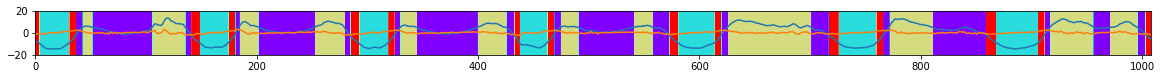

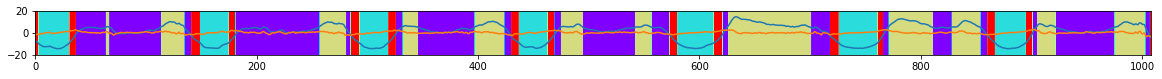

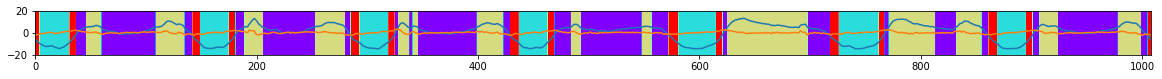

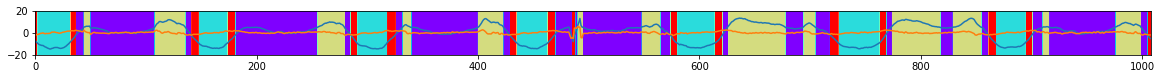

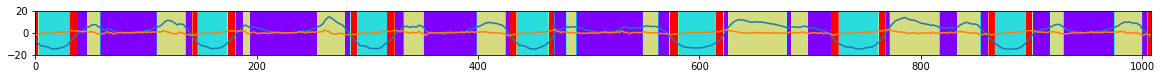

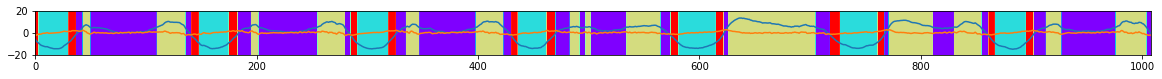

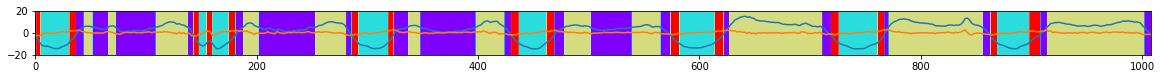

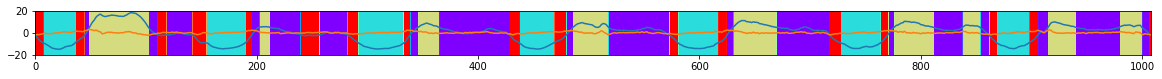

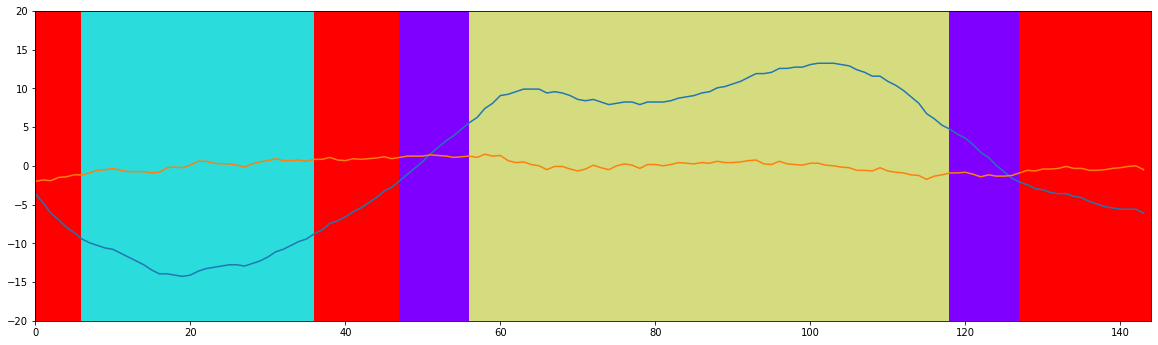

In [11]:
for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 20))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.rainbow)
    plt.show()

# Evaluation

## Day/night clustering

In [12]:
def acc_perm(a):
    return max(a, 1 - a)

In [13]:
# representation = densehmm.get_representations()
# u_fin, z_fin, z0_fin = representation
u_fin, z_fin, z0_fin = densehmm['u'], densehmm['z'], densehmm['z0']
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [14]:
kmeans = KMeans(n_clusters=2, random_state=2022).fit(uz_fin)
uz_label = kmeans.labels_
uz_label

array([1, 0, 1, 0], dtype=int32)

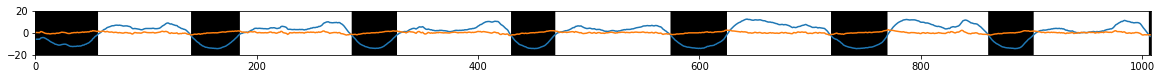

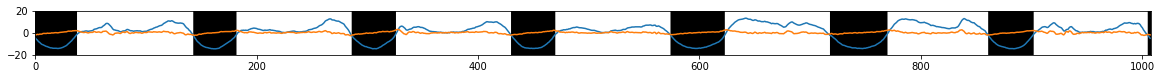

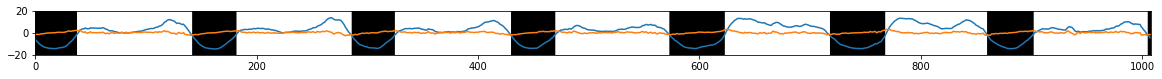

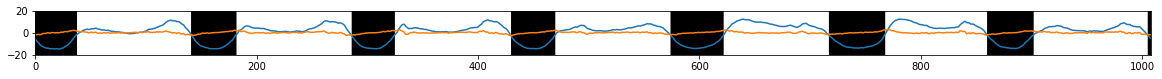

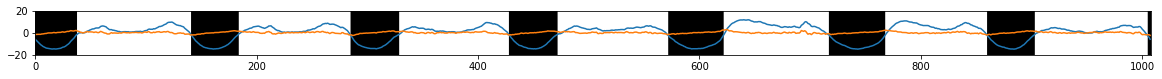

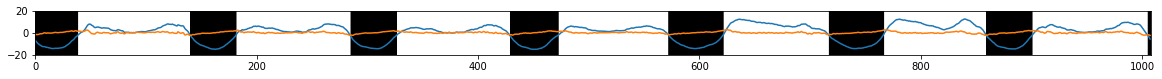

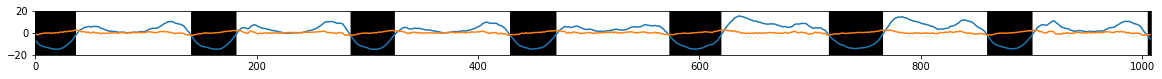

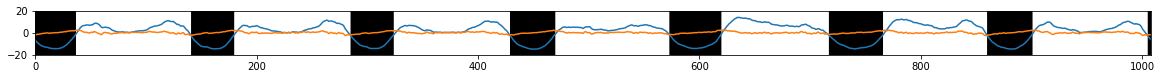

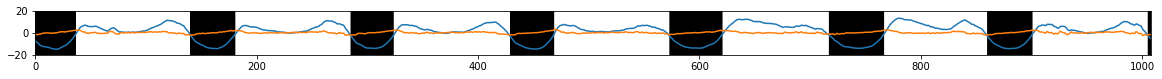

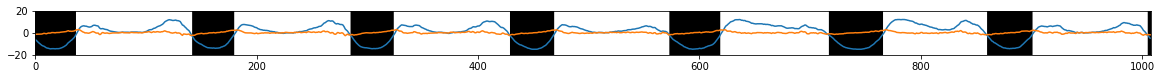

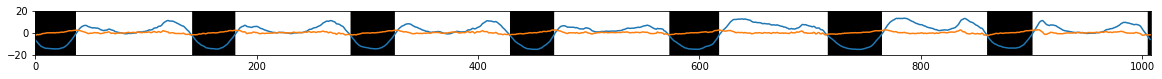

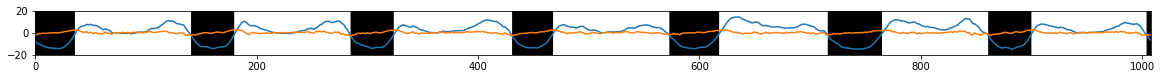

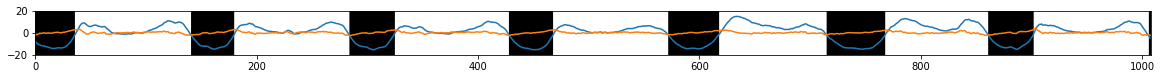

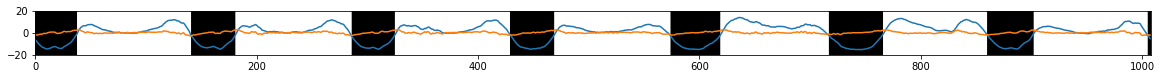

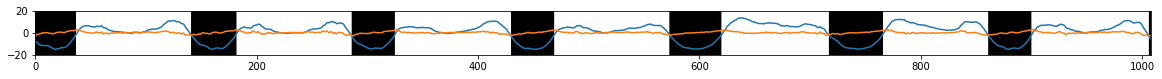

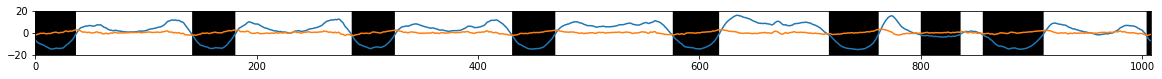

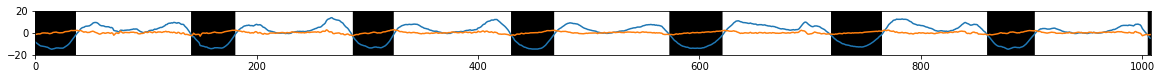

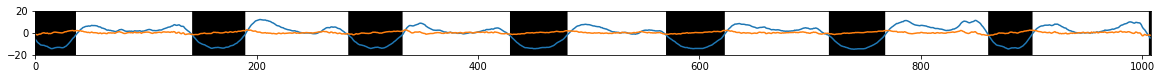

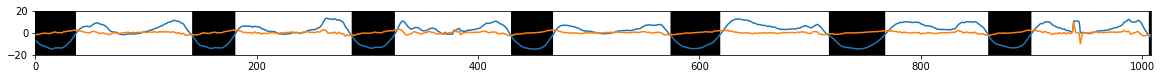

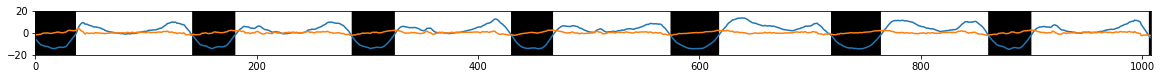

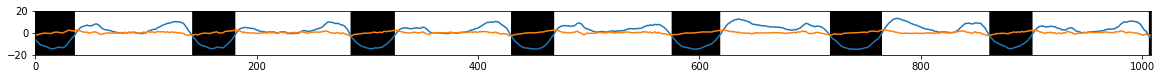

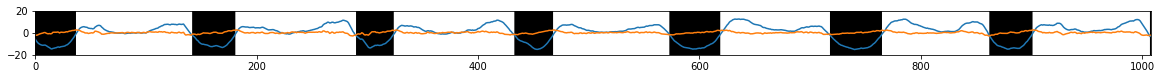

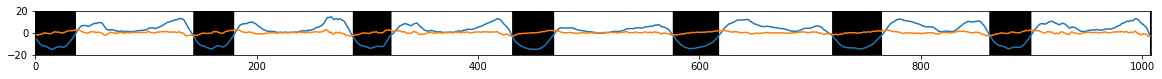

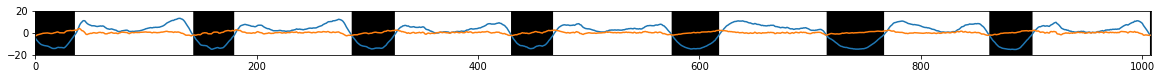

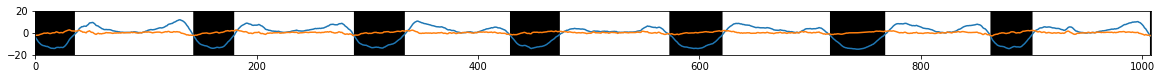

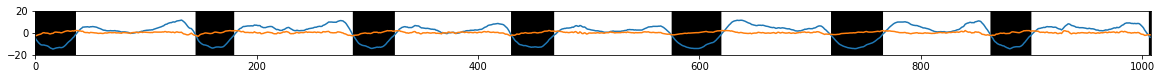

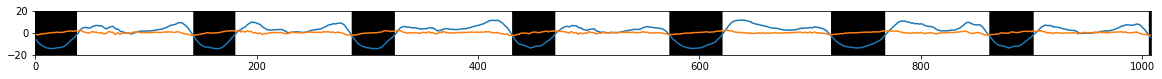

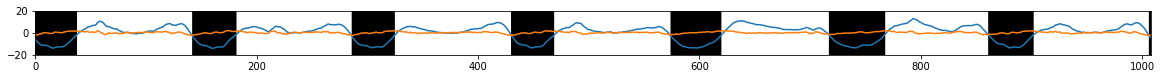

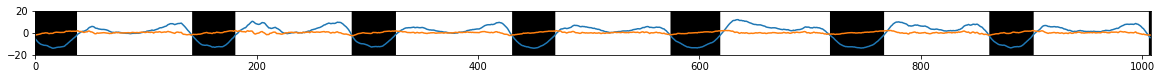

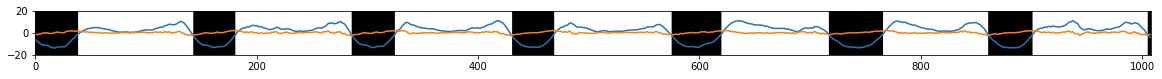

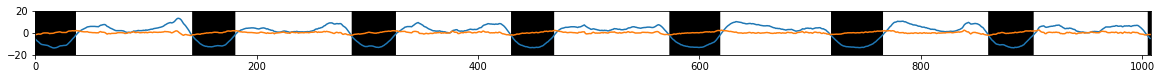

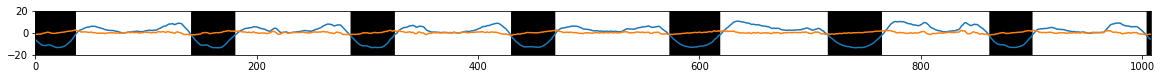

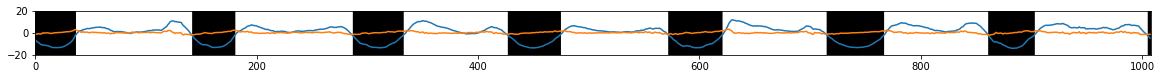

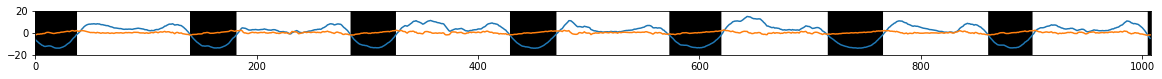

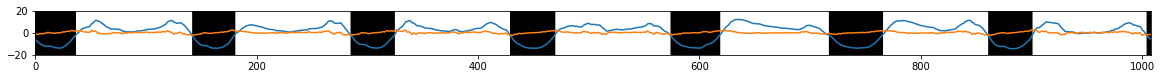

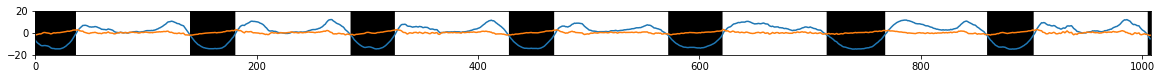

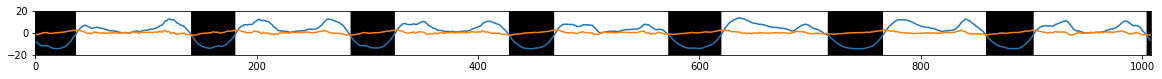

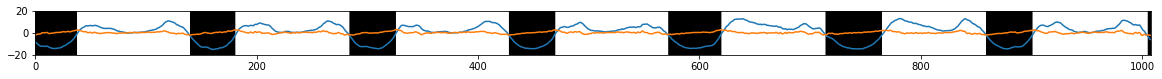

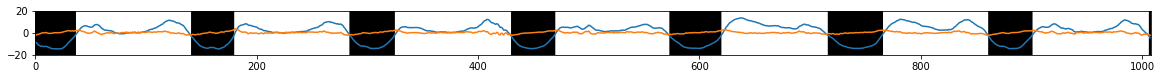

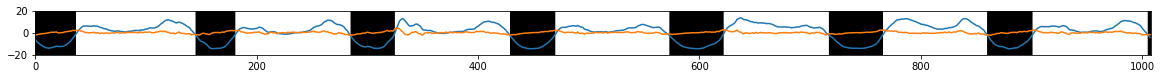

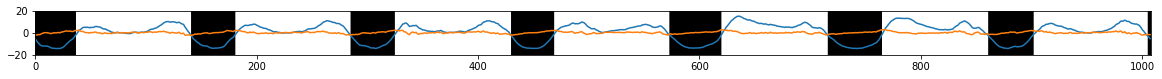

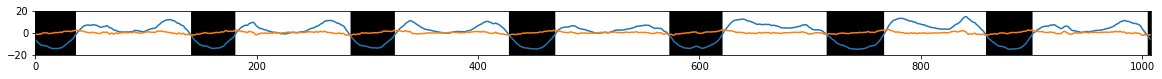

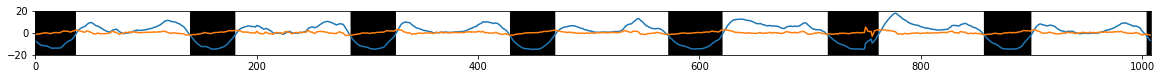

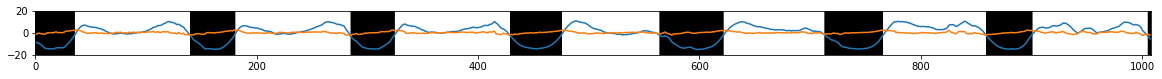

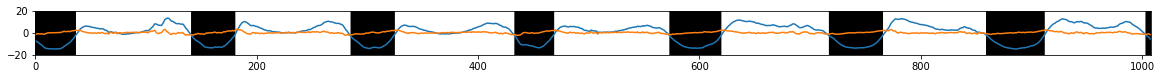

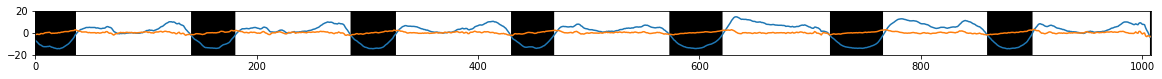

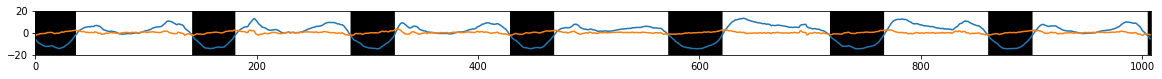

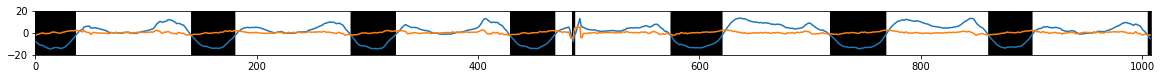

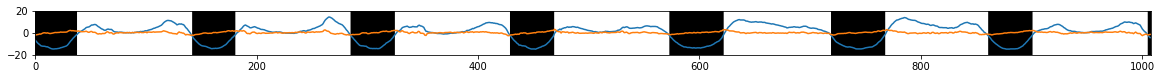

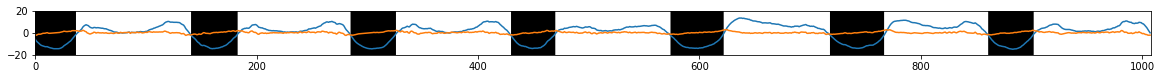

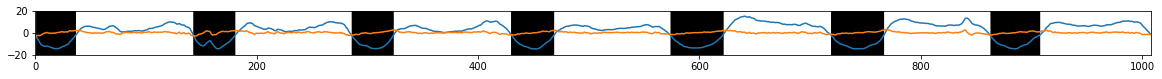

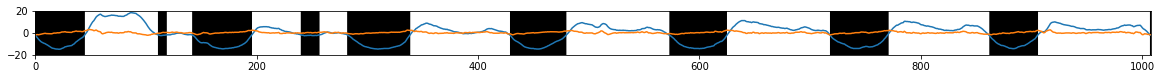

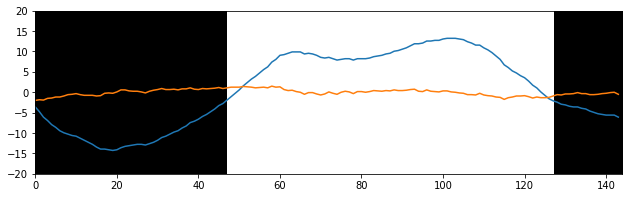

In [15]:
for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 3))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(uz_label[states[:, (i*interval) : ((i+1)*interval)]], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.gray)
    plt.show()

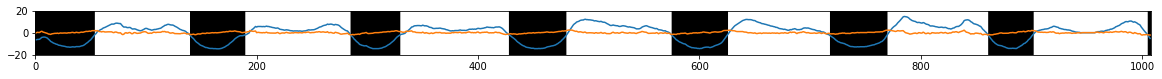

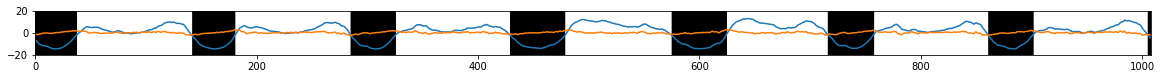

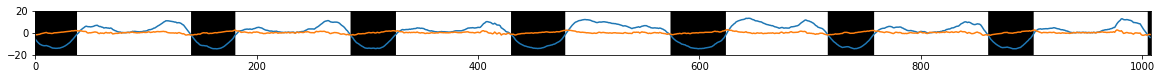

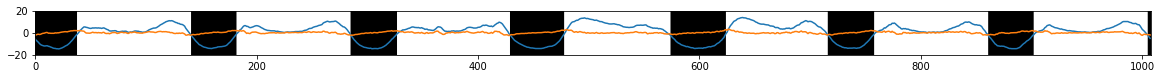

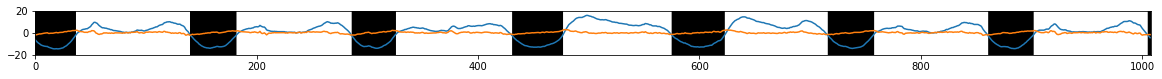

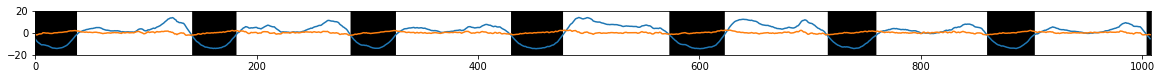

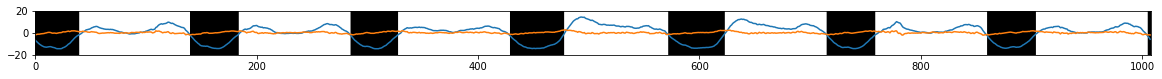

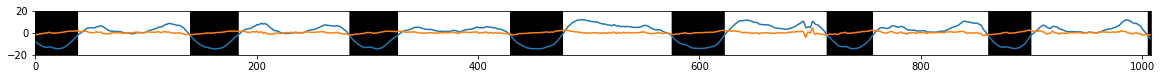

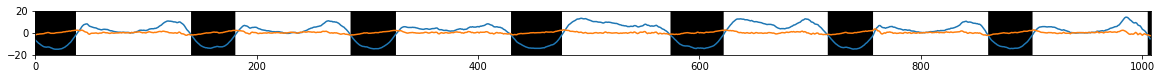

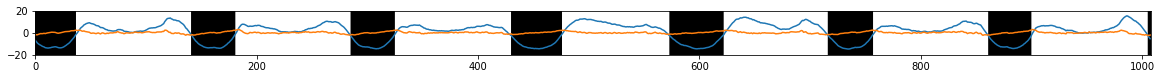

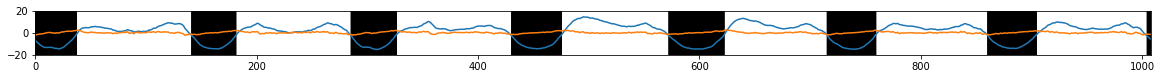

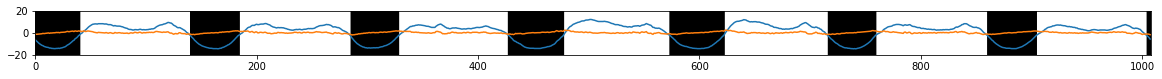

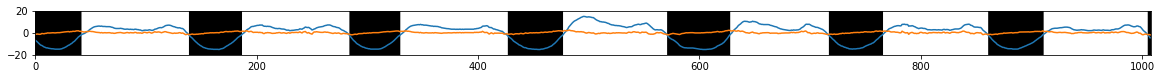

/tmp/ipykernel_924399/1103046700.py:4: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(uz_label[states_test[:, (i*interval) : ((i+1)*interval)]], extent=(0, Y_test[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.gray)


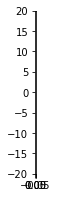

In [16]:
for i in range(Y_test.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 3))
    plt.plot(Y_test[(i*interval) : ((i+1)*interval)])
    plt.imshow(uz_label[states_test[:, (i*interval) : ((i+1)*interval)]], extent=(0, Y_test[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.gray)
    plt.show()

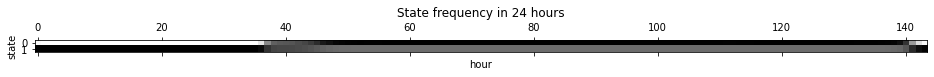

In [17]:
daily = pd.DataFrame({"states": uz_label[states].reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 6) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
daily = daily / daily.sum(axis=1).reshape(-1, 1)

plt.matshow(daily, cmap=cm.gray)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

In [18]:
daily_bin = uz_label[states].reshape(-1, 24*6)
daily_bin_test = uz_label[states_test].reshape(-1, 24*6)
daily_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [19]:
acc_final = 0
acc_test = 0
c1_final = 0
c2_final = 24*6

for c1 in range(24*6):
    for c2 in range(c1+1, 24*6):
        acc_tmp =  ((daily_bin[:, :c1] == 0).sum() + (daily_bin[:, c1:c2] == 1).sum() + (daily_bin[:, c2:] == 0).sum()) / (365 * 24 * 6)
        if acc_tmp > acc_final:
            acc_final = acc_tmp
            acc_test = ((daily_bin_test[:, :c1] == 0).sum() + (daily_bin_test[:, c1:c2] == 1).sum() + (daily_bin_test[:, c2:] == 0).sum()) / (91 * 24 * 6)
            c1_final = c1
            c2_final = c2

time_range_d = pd.date_range("00:00:00", "23:50:00", 24*6)

print(f"accuracy: {acc_final} with cutoffs {time_range_d.values[c1_final]} & {time_range_d.values[c2_final]}")
print(f"accuracy TEST: {acc_test} with cutoffs {time_range_d.values[c1_final]} & {time_range_d.values[c2_final]}")

accuracy: 0.970224505327245 with cutoffs 2022-09-26T06:20:00.000000000 & 2022-09-26T23:30:00.000000000
accuracy TEST: 0.9687118437118437 with cutoffs 2022-09-26T06:20:00.000000000 & 2022-09-26T23:30:00.000000000


## Workingday

### clustering

In [20]:
uz_fin[states.reshape(-1), :].reshape((365, -1))

array([[ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775],
       [ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775],
       [ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775],
       ...,
       [ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775],
       [ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775],
       [ 0.44202578,  0.747656  ,  0.89737073, ...,  0.747656  ,
         0.89737073, -0.29024775]])

In [21]:
Y_true.reshape(-1, 24*6*2)

array([[-6.06411385,  0.        , -5.89740835, ..., -1.91666667,
        -5.22913531, -1.58333333],
       [-6.062436  , -1.33333333, -7.06240799, ..., -1.58333333,
        -3.56871124, -1.75      ],
       [-4.56872526, -1.58333333, -5.5687428 , ..., -2.25      ,
        -4.07740888, -1.91666667],
       ...,
       [-4.77750467, -1.75      , -5.61081391, ..., -1.5       ,
        -4.10780749, -1.83333333],
       [-5.27445955, -1.83333333, -6.10777799, ..., -1.58333333,
        -2.27158651, -1.83333333],
       [-3.60489633, -2.        , -4.77153919, ...,  0.        ,
        -6.10091693, -0.5       ]])

In [22]:
kmeans_Y = KMeans(n_clusters=2, random_state=2022).fit(Y_true.reshape(-1, 24*6*2))
kmeans_s = KMeans(n_clusters=2, random_state=2022).fit(np.identity(n_)[states].reshape((365, -1)))
kmeans_e = KMeans(n_clusters=2, random_state=2022).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)))

In [23]:
# target = pd.Series(pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').min(), df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').max(), 365)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))
#
# target_test = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.dt.floor('d').min(), df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.dt.floor('d').max(), 91)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))
#
# with open("wodociagi/data_Piotr/target_working_day.pkl", "wb") as f:
#     pickle.dump(target, f)
#
#
# with open("wodociagi/data_Piotr/target_working_day_test.pkl", "wb") as f:
#     pickle.dump(target_test, f)


with open("wodociagi/data_Piotr/target_working_day.pkl", "rb") as f:
    target = pickle.load(f)

with open("wodociagi/data_Piotr/target_working_day_test.pkl", "rb") as f:
    target_test = pickle.load(f)

In [24]:
target

0       True
1      False
2      False
3      False
4       True
       ...  
360    False
361     True
362     True
363    False
364    False
Length: 365, dtype: bool

In [25]:
print(f"Holiday clustering from water demand \nTrain: {acc_perm((kmeans_Y.labels_ == target).mean())}")
print(f"Test: {(kmeans_Y.predict(Y_test.reshape(-1, 24*6*2)) == target_test).mean()}")

Holiday clustering from water demand 
Train: 0.9808219178082191
Test: 0.9230769230769231


In [26]:
print(f"Holiday clustering from state IDs \nTrain: {acc_perm((kmeans_s.labels_ == target).mean())}")
print(f"Test: {acc_perm((kmeans_s.predict(np.identity(n_)[states_test].reshape((91, -1))) == target_test).mean())}")

Holiday clustering from state IDs 
Train: 0.9780821917808219
Test: 0.9120879120879121


In [27]:
print(f"Holiday clustering from state embeddings \nTrain: {acc_perm((kmeans_e.labels_ == target).mean())}")
print(f"Test: {acc_perm((kmeans_e.predict(uz_fin[states_test.reshape(-1), :].reshape((91, -1))) == target_test).mean())}")

Holiday clustering from state embeddings 
Train: 0.9753424657534246
Test: 0.9120879120879121


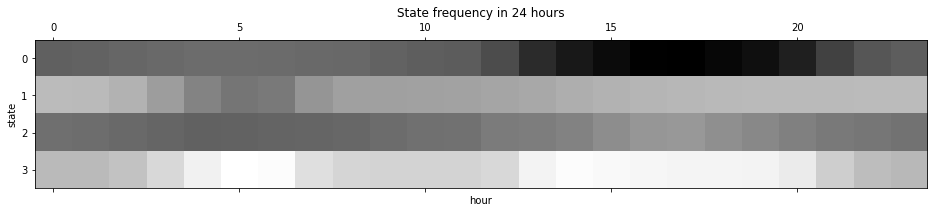

In [28]:
plt.matshow(pd.DataFrame(
    {"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24}).value_counts().reset_index().sort_values(
    ["states", "hour"]).pivot("states", "hour", 0).fillna(0).values, cmap = cm.gray_r)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

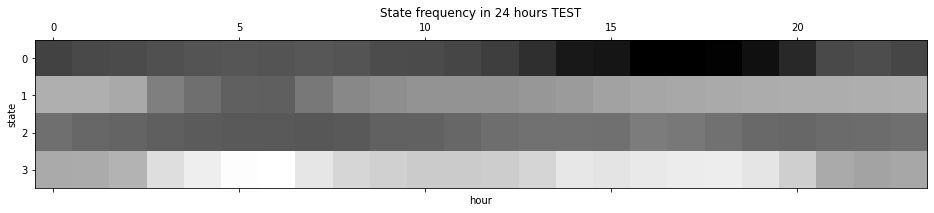

In [29]:
plt.matshow(pd.DataFrame(
    {"states": states_test.reshape(-1), "hour": np.arange(states_test.shape[1]) % 24}).value_counts().reset_index().sort_values(
    ["states", "hour"]).pivot("states", "hour", 0).fillna(0).values, cmap = cm.gray_r)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours TEST")
plt.show()

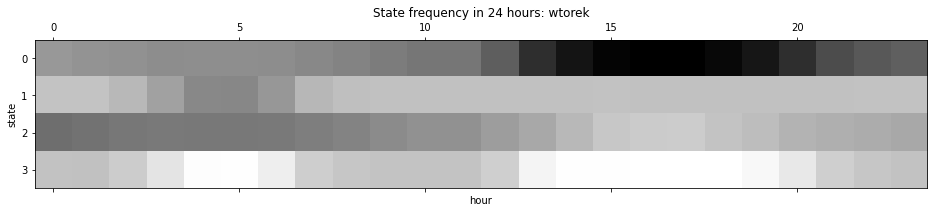

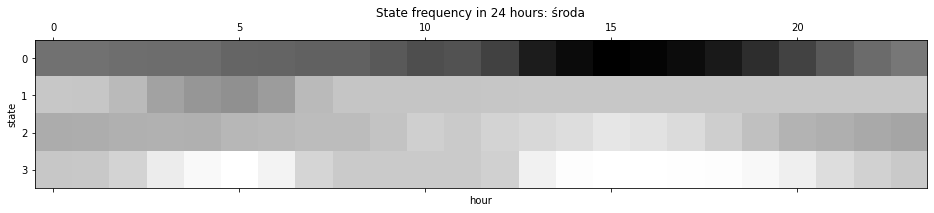

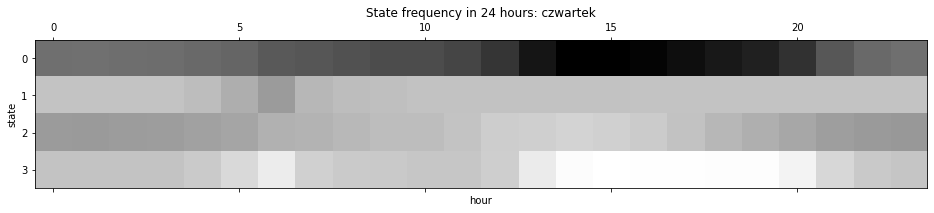

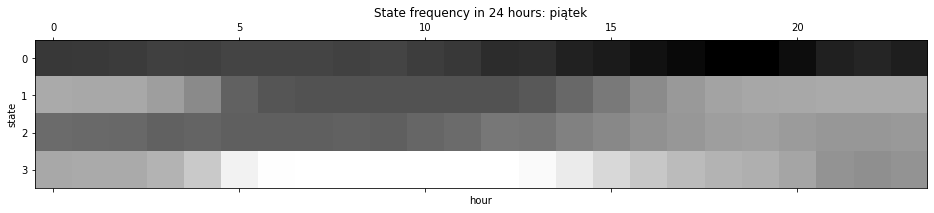

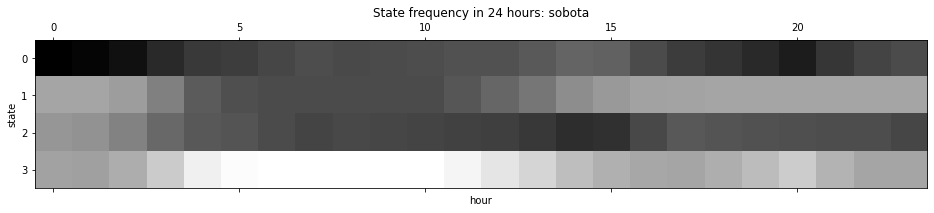

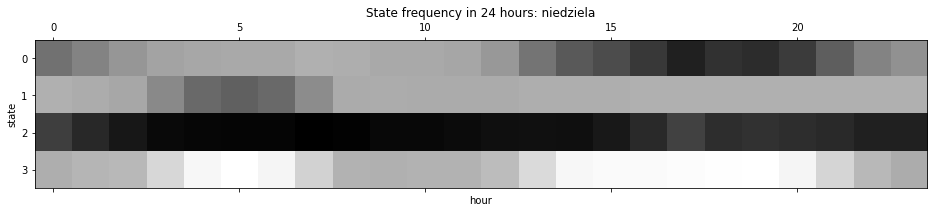

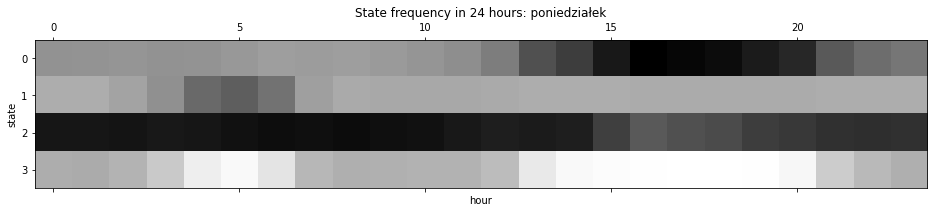

In [30]:
weekly = pd.DataFrame({"states": states.reshape(-1),
                       "hour": np.arange(states.shape[1]) % (24 * 7)}).value_counts().reset_index().sort_values(
    ["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
l = weekly.shape[1] // 7
days = ['wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'poniedziałek']
for i in range(7):
    plt.matshow(weekly[:, (l * i): (l * (i + 1))], cmap = cm.gray_r)
    plt.ylabel("state")
    plt.xlabel("hour")
    plt.title(f"State frequency in 24 hours: {days[i]}")
    plt.show()

### Classification

kNN weekday+holiday classification (using water demand): 
Train: 0.9808219178082191
Test: 0.989010989010989
kNN weekday+holiday classification (using state IDs): 
Train: 0.9808219178082191
Test: 0.967032967032967
kNN weekday+holiday classification (using state embeddings): 
Train: 0.9753424657534246
Test: 0.9560439560439561


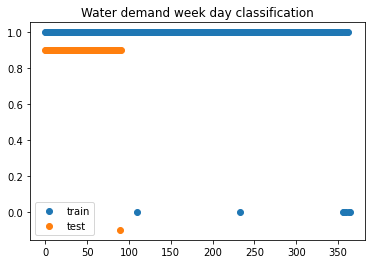

Working Day TRAIN precision: 0.9496
Working Day TRAIN recall: 0.9912
Working Day TEST  precision: 0.9655
Working Day TEST  recall: 1.0
Working Day TRAIN accuracy: 0.9808
Working Day TEST  accuracy: 0.989
Confusion matrix 
Train:
 [[245   6]
 [  1 113]]
Test:
 [[62  1]
 [ 0 28]]
kNN weekday+holiday classification acc: 
Train: 0.9808219178082191
Test: 0.989010989010989
Train Month 1: 1.0
Train Month 2: 1.0
Train Month 3: 1.0
Train Month 4: 0.9666666666666667
Train Month 5: 1.0
Train Month 6: 1.0
Train Month 7: 1.0
Train Month 8: 0.967741935483871
Train Month 9: 1.0
Train Month 10: 1.0
Train Month 11: 1.0
Train Month 12: 0.8387096774193549
Test Month 1: 1.0
Test Month 2: 1.0
Test Month 3: 0.967741935483871


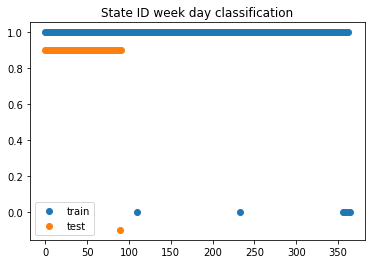

Working Day TRAIN precision: 0.9496
Working Day TRAIN recall: 0.9912
Working Day TEST  precision: 0.9655
Working Day TEST  recall: 1.0
Working Day TRAIN accuracy: 0.9808
Working Day TEST  accuracy: 0.989
Confusion matrix 
Train:
 [[245   6]
 [  1 113]]
Test:
 [[62  1]
 [ 0 28]]
kNN weekday+holiday classification acc: 
Train: 0.9808219178082191
Test: 0.989010989010989
Train Month 1: 1.0
Train Month 2: 1.0
Train Month 3: 1.0
Train Month 4: 0.9666666666666667
Train Month 5: 1.0
Train Month 6: 1.0
Train Month 7: 1.0
Train Month 8: 0.967741935483871
Train Month 9: 1.0
Train Month 10: 1.0
Train Month 11: 1.0
Train Month 12: 0.8387096774193549
Test Month 1: 1.0
Test Month 2: 1.0
Test Month 3: 0.967741935483871


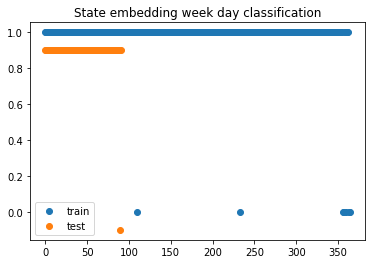

Working Day TRAIN precision: 0.9496
Working Day TRAIN recall: 0.9912
Working Day TEST  precision: 0.9655
Working Day TEST  recall: 1.0
Working Day TRAIN accuracy: 0.9808
Working Day TEST  accuracy: 0.989
Confusion matrix 
Train:
 [[245   6]
 [  1 113]]
Test:
 [[62  1]
 [ 0 28]]
kNN weekday+holiday classification acc: 
Train: 0.9808219178082191
Test: 0.989010989010989
Train Month 1: 1.0
Train Month 2: 1.0
Train Month 3: 1.0
Train Month 4: 0.9666666666666667
Train Month 5: 1.0
Train Month 6: 1.0
Train Month 7: 1.0
Train Month 8: 0.967741935483871
Train Month 9: 1.0
Train Month 10: 1.0
Train Month 11: 1.0
Train Month 12: 0.8387096774193549
Test Month 1: 1.0
Test Month 2: 1.0
Test Month 3: 0.967741935483871


In [31]:
month_len = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
month_len_test = np.cumsum([0, 31, 29, 31])

knn_Y = KNeighborsClassifier(n_neighbors=20).fit(Y_true.reshape(-1, 24 * 6 * 2), target)
knn_s = KNeighborsClassifier(n_neighbors=20).fit(np.identity(n_)[states].reshape((365, -1)), target)
knn_e = KNeighborsClassifier(n_neighbors=20).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)), target)

knn_preds_Y = knn_Y.predict(Y_true.reshape(-1, 24 * 6 * 2))
knn_preds_Y_test = knn_Y.predict(Y_test.reshape(-1, 24 * 6 * 2))

print(f"kNN weekday+holiday classification (using water demand): \nTrain: {(knn_preds_Y == target).mean()}")
print(f"Test: {(knn_preds_Y_test == target_test).mean()}")

knn_preds_s = knn_s.predict(np.identity(n_)[states].reshape((365, -1)))
knn_preds_s_test = knn_s.predict(np.identity(n_)[states_test].reshape((91, -1)))

print(f"kNN weekday+holiday classification (using state IDs): \nTrain: {(knn_preds_s == target).mean()}")
print(f"Test: {(knn_preds_s_test == target_test).mean()}")

knn_preds_e = knn_e.predict(uz_fin[states.reshape(-1), :].reshape((365, -1)))
knn_preds_e_test = knn_e.predict(uz_fin[states_test.reshape(-1), :].reshape((91, -1)))

print(f"kNN weekday+holiday classification (using state embeddings): \nTrain: {(knn_preds_e == target).mean()}")
print(f"Test: {(knn_preds_e_test == target_test).mean()}")


def present_weekday(knn_preds, knn_preds_test, title=""):
    plt.scatter(np.arange(365), knn_preds == target)
    plt.scatter(np.arange(91), (knn_preds_test == target_test) - 0.1)
    plt.title(title)
    plt.legend(['train', 'test'])
    plt.show()

    print(f"Working Day TRAIN precision: {round(precision_score(target, knn_preds), 4)}")
    print(f"Working Day TRAIN recall: {round(recall_score(target, knn_preds), 4)}")
    print(f"Working Day TEST  precision: {round(precision_score(target_test, knn_preds_test), 4)}")
    print(f"Working Day TEST  recall: {round(recall_score(target_test, knn_preds_test), 4)}")
    print(f"Working Day TRAIN accuracy: {round((target == knn_preds).mean(), 4)}")
    print(f"Working Day TEST  accuracy: {round((target_test == knn_preds_test).mean(), 4)}")

    print("Confusion matrix \nTrain:\n", confusion_matrix(target, knn_preds))
    print("Test:\n", confusion_matrix(target_test, knn_preds_test))

    print(f"kNN weekday+holiday classification acc: \nTrain: {(knn_preds_Y == target).mean()}")
    print(f"Test: {(knn_preds_Y_test == target_test).mean()}")

    for i in range(1, month_len.shape[0]):
        print(f"Train Month {i}: {(knn_preds == target)[month_len[i - 1]:month_len[i]].mean()}")
    for i in range(1, month_len_test.shape[0]):
        print(f"Test Month {i}: {(knn_preds_test == target_test)[month_len_test[i - 1]:month_len_test[i]].mean()}")


present_weekday(knn_preds_Y, knn_preds_Y_test, "Water demand week day classification")

present_weekday(knn_preds_Y, knn_preds_Y_test, "State ID week day classification")

present_weekday(knn_preds_Y, knn_preds_Y_test, "State embedding week day classification")

## Weekday

In [32]:
# target_w = pd.Series(pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').min(),
#                                    df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').max(), 365)).apply(
#     lambda d: 7 if d in holidays.PL() else d.weekday())
#
# target_w_test = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.dt.floor('d').min(),
#                                    df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.dt.floor('d').max(), 91)).apply(
#     lambda d: 7 if d in holidays.PL() else d.weekday())
#
#
# with open("wodociagi/data_Piotr/target_weekday.pkl", "wb") as f:
#     pickle.dump(target_w, f)
#
#
# with open("wodociagi/data_Piotr/target_weekday_test.pkl", "wb") as f:
#     pickle.dump(target_w_test, f)


with open("wodociagi/data_Piotr/target_weekday.pkl", "rb") as f:
    target_w = pickle.load(f)


with open("wodociagi/data_Piotr/target_weekday_test.pkl", "rb") as f:
    target_w_test = pickle.load(f)

month_len = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
month_len_test = np.cumsum([0, 31, 29, 31])

In [33]:
knn_Y = KNeighborsClassifier(n_neighbors=20).fit(Y_true.reshape(-1, 24 * 6 * 2), target_w)
knn_s = KNeighborsClassifier(n_neighbors=20).fit(np.identity(n_)[states].reshape((365, -1)), target_w)
knn_e = KNeighborsClassifier(n_neighbors=20).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)), target_w)

knn_preds_Y = knn_Y.predict(Y_true.reshape(-1, 24 * 6 * 2))
knn_preds_Y_test = knn_Y.predict(Y_test.reshape(-1, 24 * 6 * 2))

print(f"kNN weekday+holiday classification (using water demand): \nTrain: {(knn_preds_Y == target_w).mean()}")
print(f"Test: {(knn_preds_Y_test == target_w_test).mean()}")


knn_preds_s = knn_s.predict(np.identity(n_)[states].reshape((365, -1)))
knn_preds_s_test =knn_s.predict(np.identity(n_)[states_test].reshape((91, -1)))

print(f"kNN weekday+holiday classification (using state IDs): \nTrain: {(knn_preds_s == target_w).mean()}")
print(f"Test: {(knn_preds_s_test == target_w_test).mean()}")


knn_preds_e = knn_e.predict(uz_fin[states.reshape(-1), :].reshape((365, -1)))
knn_preds_e_test = knn_e.predict(uz_fin[states_test.reshape(-1), :].reshape((91, -1)))

print(f"kNN weekday+holiday classification (using state embeddings): \nTrain: {(knn_preds_e == target_w).mean()}")
print(f"Test: {(knn_preds_e_test == target_w_test).mean()}")


kNN weekday+holiday classification (using water demand): 
Train: 0.6301369863013698
Test: 0.5934065934065934
kNN weekday+holiday classification (using state IDs): 
Train: 0.5561643835616439
Test: 0.4725274725274725
kNN weekday+holiday classification (using state embeddings): 
Train: 0.5589041095890411
Test: 0.43956043956043955


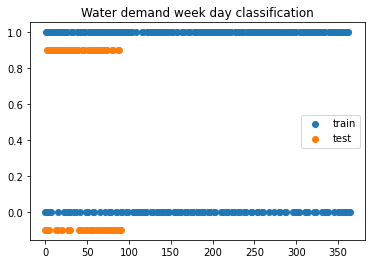

Day 0 TRAIN precision: 0.4444
Day 0 TRAIN recall: 0.56
Day 0 TEST  precision: 0.4444
Day 0 TEST  recall: 0.3333
Day 1 TRAIN precision: 0.339
Day 1 TRAIN recall: 0.3846
Day 1 TEST  precision: 0.5
Day 1 TEST  recall: 0.3846
Day 2 TRAIN precision: 0.5667
Day 2 TRAIN recall: 0.34
Day 2 TEST  precision: 0.4167
Day 2 TEST  recall: 0.4167
Day 3 TRAIN precision: 0.5429
Day 3 TRAIN recall: 0.3878
Day 3 TEST  precision: 0.75
Day 3 TEST  recall: 0.2308
Day 4 TRAIN precision: 0.7627
Day 4 TRAIN recall: 0.9
Day 4 TEST  precision: 0.44
Day 4 TEST  recall: 0.8462
Day 5 TRAIN precision: 0.8254
Day 5 TRAIN recall: 1.0
Day 5 TEST  precision: 0.8667
Day 5 TEST  recall: 1.0
Day 6 TRAIN precision: 0.8704
Day 6 TRAIN recall: 0.9592
Day 6 TEST  precision: 0.8125
Day 6 TEST  recall: 1.0
Day 7 TRAIN precision: 1.0
Day 7 TRAIN recall: 0.1538
Day 7 TEST  precision: 0.0
Day 7 TEST  recall: 0.0
Working Day TRAIN precision: 0.9959
Working Day TRAIN recall: 0.9761
Working Day TRAIN accuracy: 0.9808
Working Day TEST 

/ziob/klaudia/miniconda3/envs/hmm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


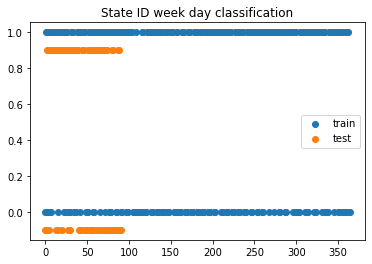

Day 0 TRAIN precision: 0.4444
Day 0 TRAIN recall: 0.56
Day 0 TEST  precision: 0.4444
Day 0 TEST  recall: 0.3333
Day 1 TRAIN precision: 0.339
Day 1 TRAIN recall: 0.3846
Day 1 TEST  precision: 0.5
Day 1 TEST  recall: 0.3846
Day 2 TRAIN precision: 0.5667
Day 2 TRAIN recall: 0.34
Day 2 TEST  precision: 0.4167
Day 2 TEST  recall: 0.4167
Day 3 TRAIN precision: 0.5429
Day 3 TRAIN recall: 0.3878
Day 3 TEST  precision: 0.75
Day 3 TEST  recall: 0.2308
Day 4 TRAIN precision: 0.7627
Day 4 TRAIN recall: 0.9
Day 4 TEST  precision: 0.44
Day 4 TEST  recall: 0.8462
Day 5 TRAIN precision: 0.8254
Day 5 TRAIN recall: 1.0
Day 5 TEST  precision: 0.8667
Day 5 TEST  recall: 1.0
Day 6 TRAIN precision: 0.8704
Day 6 TRAIN recall: 0.9592
Day 6 TEST  precision: 0.8125
Day 6 TEST  recall: 1.0
Day 7 TRAIN precision: 1.0
Day 7 TRAIN recall: 0.1538
Day 7 TEST  precision: 0.0
Day 7 TEST  recall: 0.0
Working Day TRAIN precision: 0.9959
Working Day TRAIN recall: 0.9761
Working Day TRAIN accuracy: 0.9808
Working Day TEST 

/ziob/klaudia/miniconda3/envs/hmm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


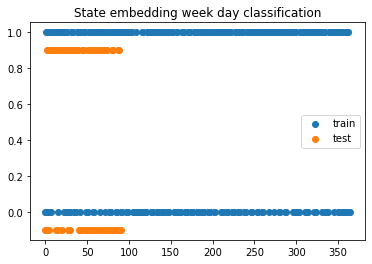

Day 0 TRAIN precision: 0.4444
Day 0 TRAIN recall: 0.56
Day 0 TEST  precision: 0.4444
Day 0 TEST  recall: 0.3333
Day 1 TRAIN precision: 0.339
Day 1 TRAIN recall: 0.3846
Day 1 TEST  precision: 0.5
Day 1 TEST  recall: 0.3846
Day 2 TRAIN precision: 0.5667
Day 2 TRAIN recall: 0.34
Day 2 TEST  precision: 0.4167
Day 2 TEST  recall: 0.4167
Day 3 TRAIN precision: 0.5429
Day 3 TRAIN recall: 0.3878
Day 3 TEST  precision: 0.75
Day 3 TEST  recall: 0.2308
Day 4 TRAIN precision: 0.7627
Day 4 TRAIN recall: 0.9
Day 4 TEST  precision: 0.44
Day 4 TEST  recall: 0.8462
Day 5 TRAIN precision: 0.8254
Day 5 TRAIN recall: 1.0
Day 5 TEST  precision: 0.8667
Day 5 TEST  recall: 1.0
Day 6 TRAIN precision: 0.8704
Day 6 TRAIN recall: 0.9592
Day 6 TEST  precision: 0.8125
Day 6 TEST  recall: 1.0
Day 7 TRAIN precision: 1.0
Day 7 TRAIN recall: 0.1538
Day 7 TEST  precision: 0.0
Day 7 TEST  recall: 0.0
Working Day TRAIN precision: 0.9959
Working Day TRAIN recall: 0.9761
Working Day TRAIN accuracy: 0.9808
Working Day TEST 

/ziob/klaudia/miniconda3/envs/hmm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
def present_weekday(knn_preds, knn_preds_test, title=""):
    plt.scatter(np.arange(365), knn_preds == target_w)
    plt.scatter(np.arange(91), (knn_preds_test == target_w_test) - 0.1)
    plt.title(title)
    plt.legend(['train', 'test'])
    plt.show()

    for i in range(8):
        print(f"Day {i} TRAIN precision: {round(precision_score(target_w == i, knn_preds == i), 4)}")
        print(f"Day {i} TRAIN recall: {round(recall_score(target_w == i, knn_preds == i), 4)}")
        print(f"Day {i} TEST  precision: {round(precision_score(target_w_test == i, knn_preds_test == i), 4)}")
        print(f"Day {i} TEST  recall: {round(recall_score(target_w_test == i, knn_preds_test == i), 4)}")

    print(f"Working Day TRAIN precision: {round(precision_score(target_w < 5, knn_preds < 5), 4)}")
    print(f"Working Day TRAIN recall: {round(recall_score(target_w < 5, knn_preds < 5), 4)}")
    print(f"Working Day TRAIN accuracy: {round(((target_w < 5) == (knn_preds < 5)).mean(), 4)}")
    print(f"Working Day TEST  precision: {round(precision_score(target_w_test < 5, knn_preds_test < 5), 4)}")
    print(f"Working Day TEST  recall: {round(recall_score(target_w_test < 5, knn_preds_test < 5), 4)}")
    print(f"Working Day TEST  accuracy: {round(((target_w_test < 5) == (knn_preds_test < 5)).mean(), 4)}")

    print("Confusion matrix \nTrain:\n", confusion_matrix(target_w, knn_preds))
    print("Test:\n", confusion_matrix(target_w_test, knn_preds_test))

    print(f"kNN weekday+holiday classification acc: \nTrain: {(knn_preds_Y == target_w).mean()}")
    print(f"Test: {(knn_preds_Y_test == target_w_test).mean()}")

    for i in range(1, month_len.shape[0]):
        print(f"Train Month {i}: {(knn_preds == target_w)[month_len[i - 1]:month_len[i]].mean()}")
    for i in range(1, month_len_test.shape[0]):
        print(f"Test Month {i}: {(knn_preds_test == target_w_test)[month_len_test[i - 1]:month_len_test[i]].mean()}")

present_weekday(knn_preds_Y, knn_preds_Y_test, "Water demand week day classification")

present_weekday(knn_preds_Y, knn_preds_Y_test, "State ID week day classification")

present_weekday(knn_preds_Y, knn_preds_Y_test, "State embedding week day classification")


In [35]:
# Confusion matrices

In [36]:
# acc in months